### Table of Contents
- [Getting started](#Getting-Started)
    - [Set score baseline](#Set-score-baseline)
    - [Sampling](#Sampling)
    - [Feature selection](#Feature-selection)
- [Feature by Feature Exploration](#Feature-by-Feature-Exploration)
    - [What does my intuition tell me?](#What-does-my-intuition-tell-me?)
    - [Type](#Type)
    - Photo
    - Video
    - Description
    - Quantity
    - Age
    - Health
    - Breed
    - Color
    - Size
    - Fur
    - Gender
    - State
    - Rescuer
- External Data
    - PetFinder.com (vs .my)
    - What breeds are good with...
- Model Tweaking

# Getting Started

In [143]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import warnings
import json
import os

# Options
warnings.filterwarnings(action='ignore')
sns.set_palette('YlGnBu')
%config InlineBackend.figure_format='retina'

In [5]:
def reset_dfs():
    global train_df, test_df
    train_df = pd.read_csv('../input/train/train.csv')
    test_df = pd.read_csv('../input/test/test.csv')
reset_dfs()

## Set score baseline
Let's put the cart before the horse. 
Let's get our data cleaning and feature building pipeline set up so that as we can progressively validate our hypotheses moving forward. 

The idea here is to produce the simplest, most basic predictions to use as a starting point for the rest of the process of score improvement. 

#### Explore the accompanying script, which contains the resulting data cleaning / feature building functions: 
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building

According to the competition details, the evaluation metric is a **quadratic weighted kappa**, which sounds super complicated. Luckily, there is a function that I found [here](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py) and that is used in few kernels. 

**Baseline Local Score: 0.07917**  
Leaderboard Score: 0.090  
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building?scriptVersionId=9976702

In [3]:
'''
Score:  0.07917
   AdoptionSpeed  Type_2
0              2       1
1              0       1
''';

## Sampling
In typical beginner fashion, I'm going to use a new and shiny strategy that I just learned about [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets): sampling to overcome issues related to imbalances in the target feature counts.

**Is there an imbalance in the target feature?**

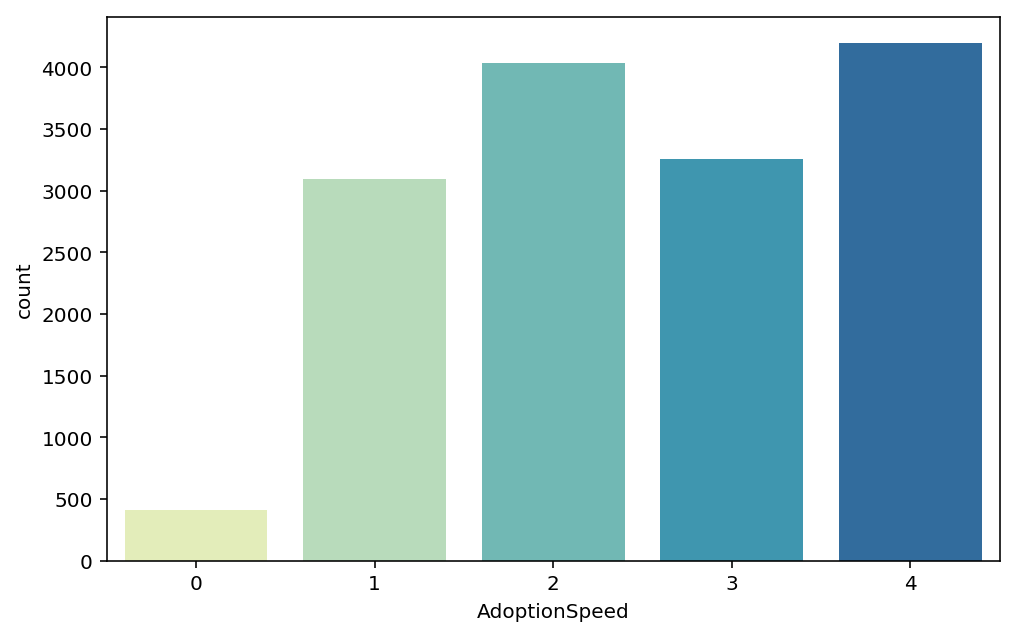

In [4]:
reset_dfs()
plt.figure(figsize=(8,5))
sns.countplot(train_df['AdoptionSpeed']);

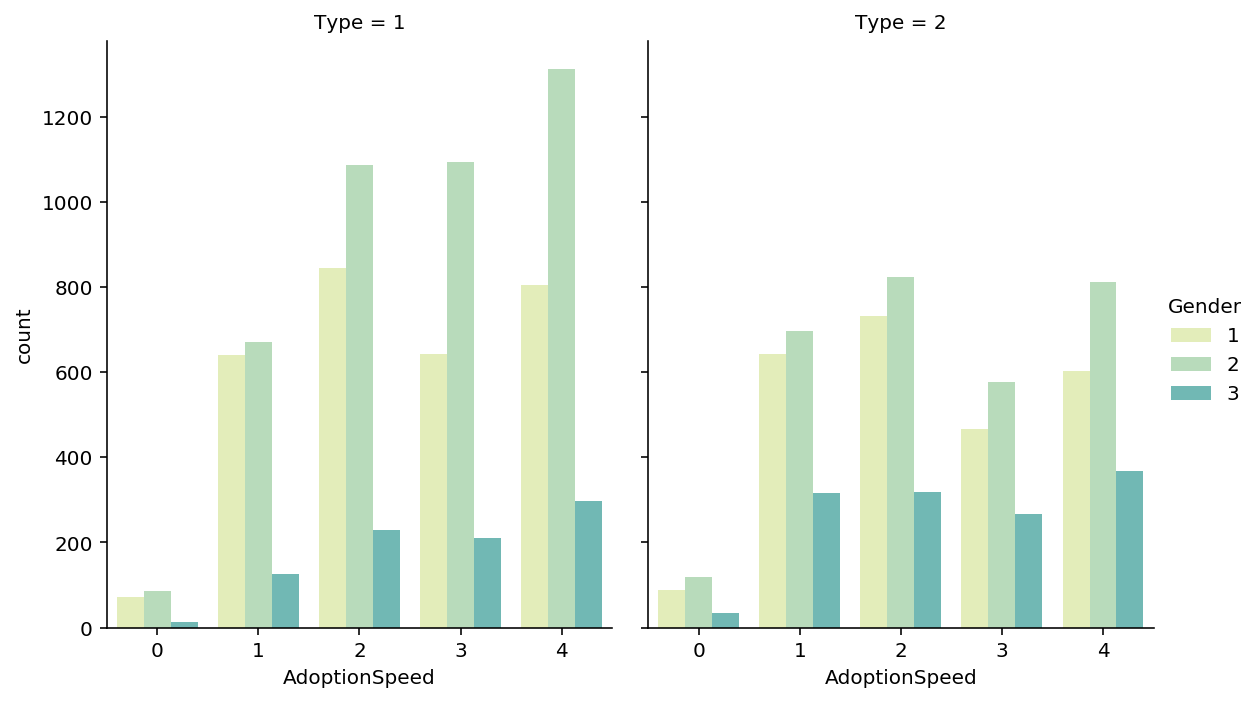

In [5]:
g = sns.catplot("AdoptionSpeed", col="Type",
                hue="Gender", data=train_df,
                kind="count", height=5, aspect=.8);

It appears that there is a low proportion of pets who are adopted on the day they was listed on PetFinder.

Let's look into a few oversampling strategies to address the problem statement described [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets). 

### df.sample()
There is a built-in pandas method to quickly under- or over-sample.  
Below, I've created a funtion to take a list of lists that contain the target values to resample from/to.  
The first item in each list is the target value being sample, either under or over, depending on whether there are more or less of the second item in each list. 

In [6]:
def sample(df, target_val_sets):
    for target_val_set in target_val_sets:
        df_class_0 = df[df['AdoptionSpeed'] == target_val_set[0]]
        count_1 = df['AdoptionSpeed'].value_counts()[target_val_set[1]]
        df_class_0_sampled = df_class_0.sample(count_1,replace='True')
        df = pd.merge(df.drop(df_class_0.index),
                      df_class_0_sampled, how='outer')
    return df

# Over sample where AdoptionSpeed == 0, to match the count of AdoptionSpeed == 1
train_df = sample(train_df, [[0, 1]])

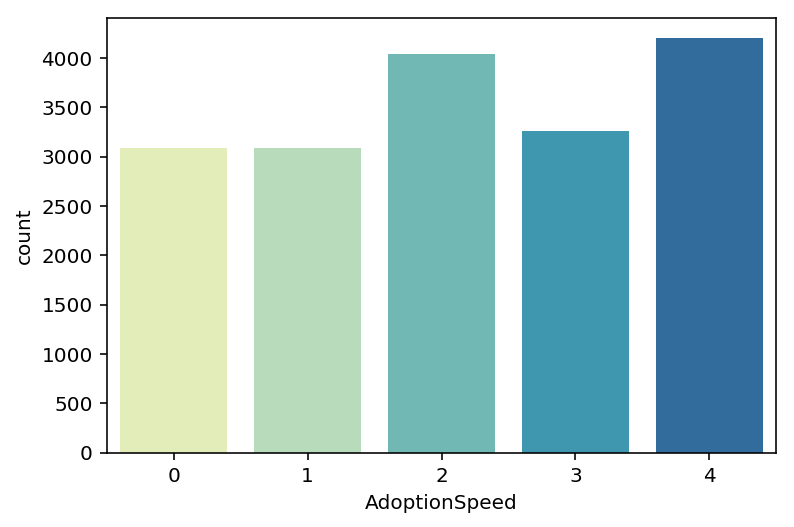

In [7]:
# Note how counts of 0 and 1 now match:
sns.countplot(train_df['AdoptionSpeed']);

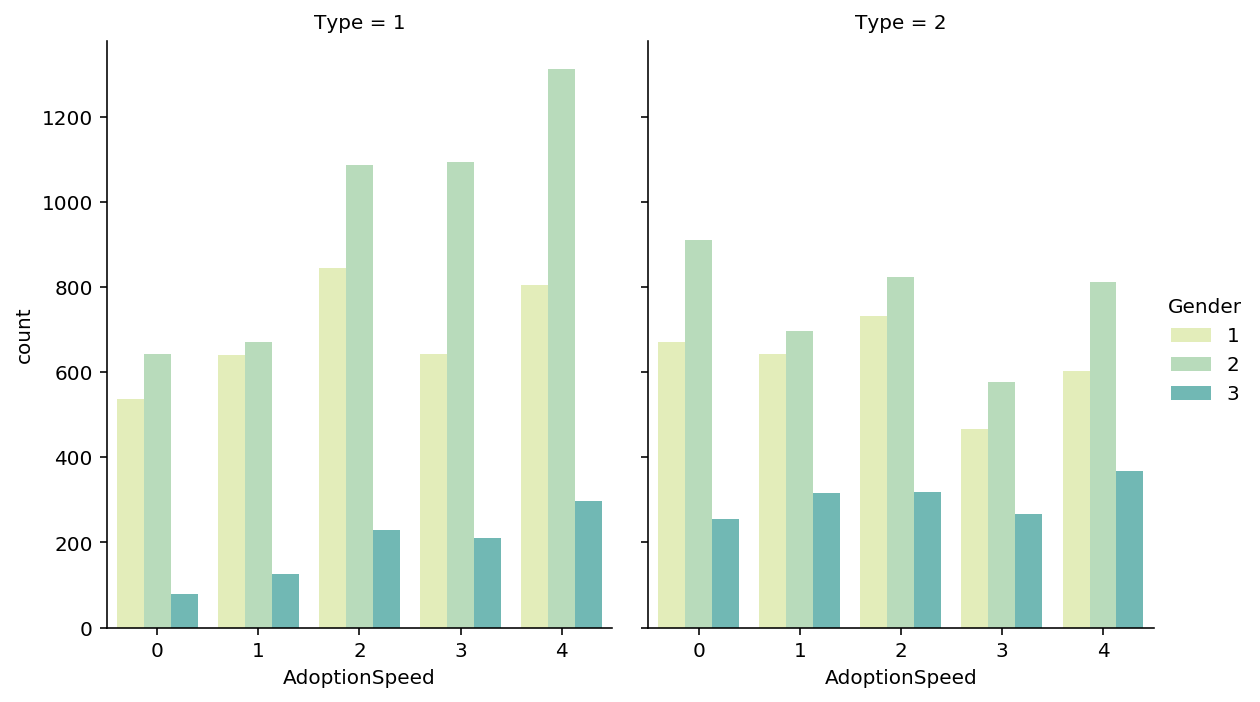

In [8]:
g = sns.catplot("AdoptionSpeed", col="Type",
                hue="Gender", data=train_df,
                kind="count", height=5, aspect=.8);

**What effect does randomly sampling using the pandas .sample() method have on our current local score**?  
Current Baseline: 0.07924  
New Score:  0.09349  
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building?scriptVersionId=9976791  

In [9]:
'''
Score:  0.09349
   AdoptionSpeed  Type_2
0              2       1
1              3       0
''';

### RandomUnderSampler()

In [10]:
X = train_df.drop('AdoptionSpeed', axis=1)
y = train_df['AdoptionSpeed']
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='minority',
                                    random_state=1)
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

1107 new random picked points


In [11]:
resampled_df = pd.DataFrame(list(X_ros), columns=train_df.drop('AdoptionSpeed', axis=1).columns)
resampled_df['AdoptionSpeed'] = list(y_ros)
resampled_df.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3


What is different here is that the minority ('AdoptionSpeed' == 0) is getting oversampled to match ('AdoptionSpeed' == 4). Not sure if that is good or bad...

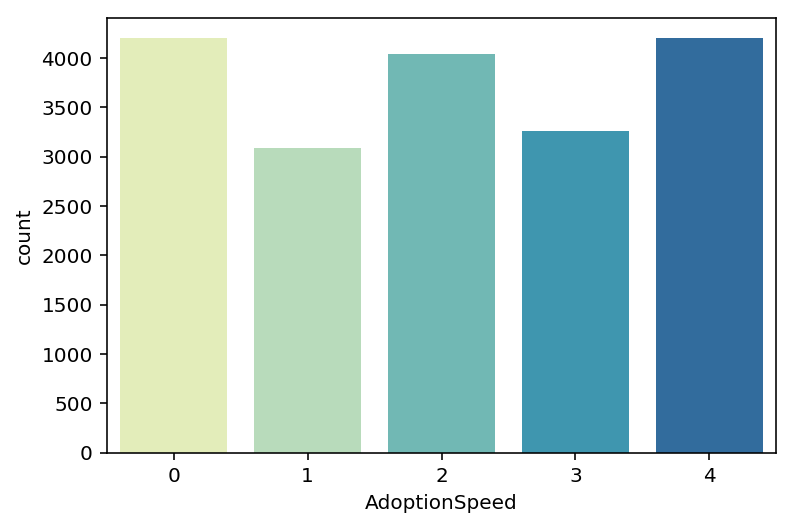

In [12]:
sns.countplot(resampled_df['AdoptionSpeed']);

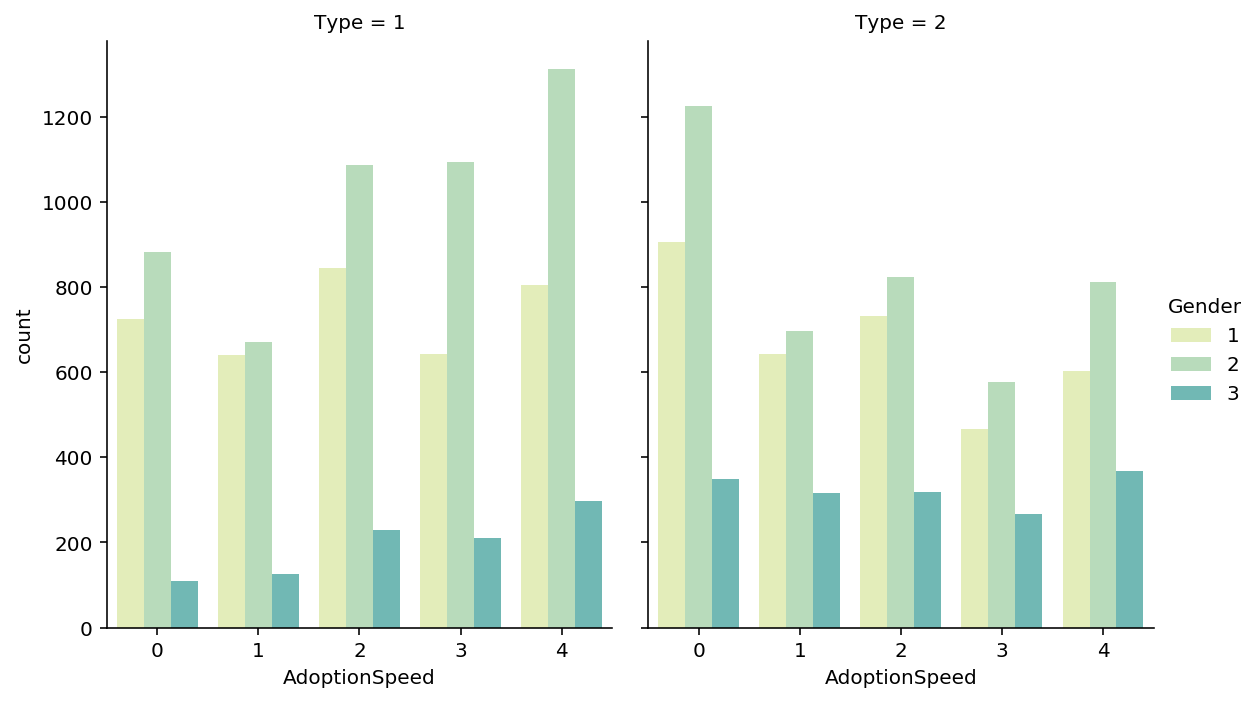

In [13]:
sns.catplot("AdoptionSpeed", col="Type",
                hue="Gender", data=resampled_df,
                kind="count", height=5, aspect=.8);

That certainly did *something*, right?  
Let's check our local score. 

**What effect does random over-sampling with imbalanced-learn affect have on our local score?**  
What effect does randomly sampling using the pandas .sample() method have on our current local score?  
Current Baseline: 0.09349  
New Local Score: 0.12413  
Leaderboard Score: 0.086  
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building?scriptVersionId=9977273

In [14]:
'''
Score:  0.12413
   AdoptionSpeed  Type_2
0              2       1
1              0       1

''';

Sampling at this point may not be the right strategy as it will be difficult to asses its value, given that we have not necessarily provided the random oversampler with much to go by. Increasing the number of samples with only "Type" as a feature may reduce accuracy rather than improve it. 

### Feature selection
You may have noticed that we have only one feature that we're using to build our model (Type == 2).  

Obviously, we could do with more and get a better score, before even engineering anything new.  

What would be nice if we build in some forward feature selection into our workflow so that as we engineer features, we find out if they make the cut or not! (I could be totally wrong here, but come along for the ride anyway)  
https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html

# Feature by Feature Exploration

## What does my intuition tell me?
It's easy to jump straight into "building" features before thinking through the bigger picture.  

In this case, it might be a literal picture, since animal photos could very well be the big feature. 

Before jumping into the data, it's useful to take a look at mypetfinder.my to see what features standout as means by which visitors would go about narrowing their options and choosing a pet to adopt. 

**What comes across in looking at petfinder.my:**
- **Insight:** Photos are presented as the primary means to navigate the website.
    - **So what:** this feature could override other attributes as a predictor for adoption speed. 
- **Insight:** Filtering is quite challenging and hidden. 
    - **So what:** attributes that may *appear* important to us, may not be part of the typical visitor's journey on the website and therefore may not be playing a major role in adoption speeds. 
- **Insight:** Once on a pet detail page, additional photos are found at the bottom (and not easily scannable at top)
    - **So what:** The first photo may be playing an outsized role. If there's a way to infer what the first photo in the pet's list of photos is, that might be the one to focus on. 

**Who would you rather adopt?**
Some pets might be the ideal breed, in perfect health and just the right age, but if their photo(s) don't do them justice, then they may have a slow adoption speed. 

Peak Cuteness | Maybe Cute
- | -
![Dog 1](../input/train_images/0a9f9f178-7.jpg) | ![Dog 2](../input/train_images/0b3deeb66-2.jpg)
![Cat 1](../input/train_images/0a7798d2b-8.jpg ) | ![Cat 2](../input/train_images/0a2073b86-2.jpg)

## Type

## Photo  

Questions: 
- Is there a way to tell if photos are of good or bad quality? 
- If we can do the above, does it seem to make a difference on speed of adoption?
- Do most pets have photos? If they don't does it make a big difference? 
- Does it matter if pets have many photos? Too few? 

Let's get a better understanding of what a "good" photo looks like, according to Google's Vision API.

Here is a pretty good image that we could consider as "good": 
![Dog 1](../input/train_images/0a9f9f178-7.jpg)

What does Google think this photo is about? 

In [25]:
score = 0
with open('../input/train_metadata/0a9f9f178-7.json') as f:
    good_image = json.load(f)
for label in good_image['labelAnnotations']:
    if label['description'] == 'dog':
        score = label['score']
print(score)

0.96165854


Let's get a better understanding of what a "not good" photo looks like, according to Google's Vision API.

Here is a not so great image that we could consider as "not so good": 
![Dog 2](../input/train_images/0b3deeb66-2.jpg)

In [24]:
score = 0
with open('../input/train_metadata/0b3deeb66-2.json') as f:
    good_image = json.load(f)
for label in good_image['labelAnnotations']:
    if label['description'] == 'dog':
        score = label['score']
print(score)

0


The second image did worse than I had expected! Turns out the closest label to "dog" is the following: 

In [19]:
{
    "description": "dog like mammal",
    "score": 0.77083683,
};

**Watch out:** The latest version of the Google Vision API may have gotten better at labeling images. Running a few of these image through [this page](https://cloud.google.com/vision/) resulted in more precise scores.  

In [106]:
def get_photo_score(x, match='exact', start=1, stop=2, multiple=False):
    pet_id = x
    pet_type = train_df[train_df['PetID'] == pet_id]['Type'].values[0]
    pet_type_dict = {1: 'dog', 2: 'cat'}
    pet_type = pet_type_dict[pet_type]
    scores = []
    score = 0
    i = start
    while (i > 0) & (i < stop):
        json_file = '../input/train_metadata/' + pet_id + '-' + str(i) + '.json'
        if os.path.isfile(json_file):
            with open(json_file) as f:
                try:
                    image_data = False
                    image_data = pd.DataFrame(json.load(f)['labelAnnotations'])
                except Exception:
                    pass
            try:
                if match == 'exact':
                    scores.append(image_data[image_data['description'] == pet_type]['score'].values[0])
                if match == 'contains':
                    scores.append(image_data[image_data['description'].str.contains(pet_type)]['score'].values.max())
            except Exception:
                scores.append(.0)
                pass
            i += 1
        else:
            break
    try:
        if not multiple:
            if (stop-start) > 1:
                score = np.array(scores).mean()
            if (stop-start) == 1:
                score = np.array(scores).max()
        if multiple:
            score = np.array(scores)
    except Exception:
        pass
    return score

train_df['FirstPhotoScore'] = train_df['PetID'].apply(lambda x: get_photo_score(x, match='exact', start=1, stop=2, multiple=False))

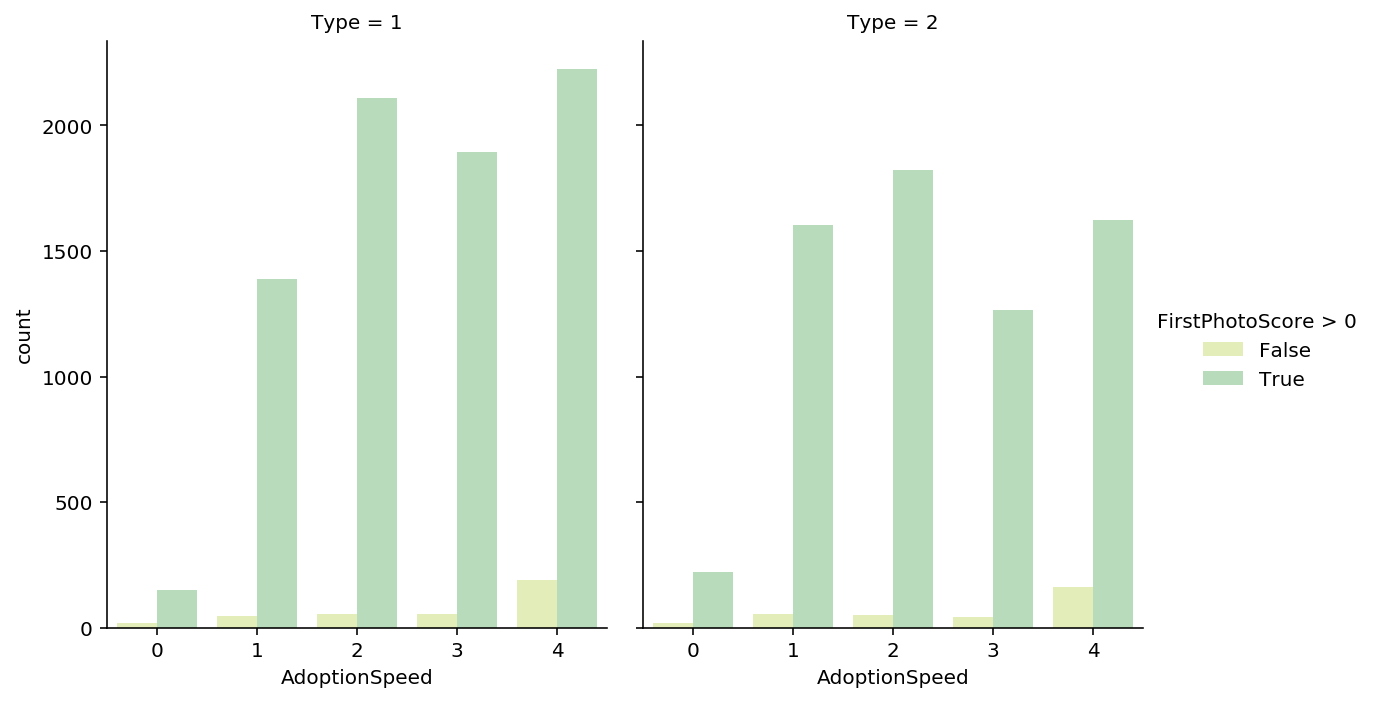

In [98]:
train_df['FirstPhotoScore > 0'] = train_df['FirstPhotoScore'] > 0

sns.catplot("AdoptionSpeed", col="Type",
                hue="FirstPhotoScore > 0", data=train_df,
                kind="count", height=5, aspect=.8);

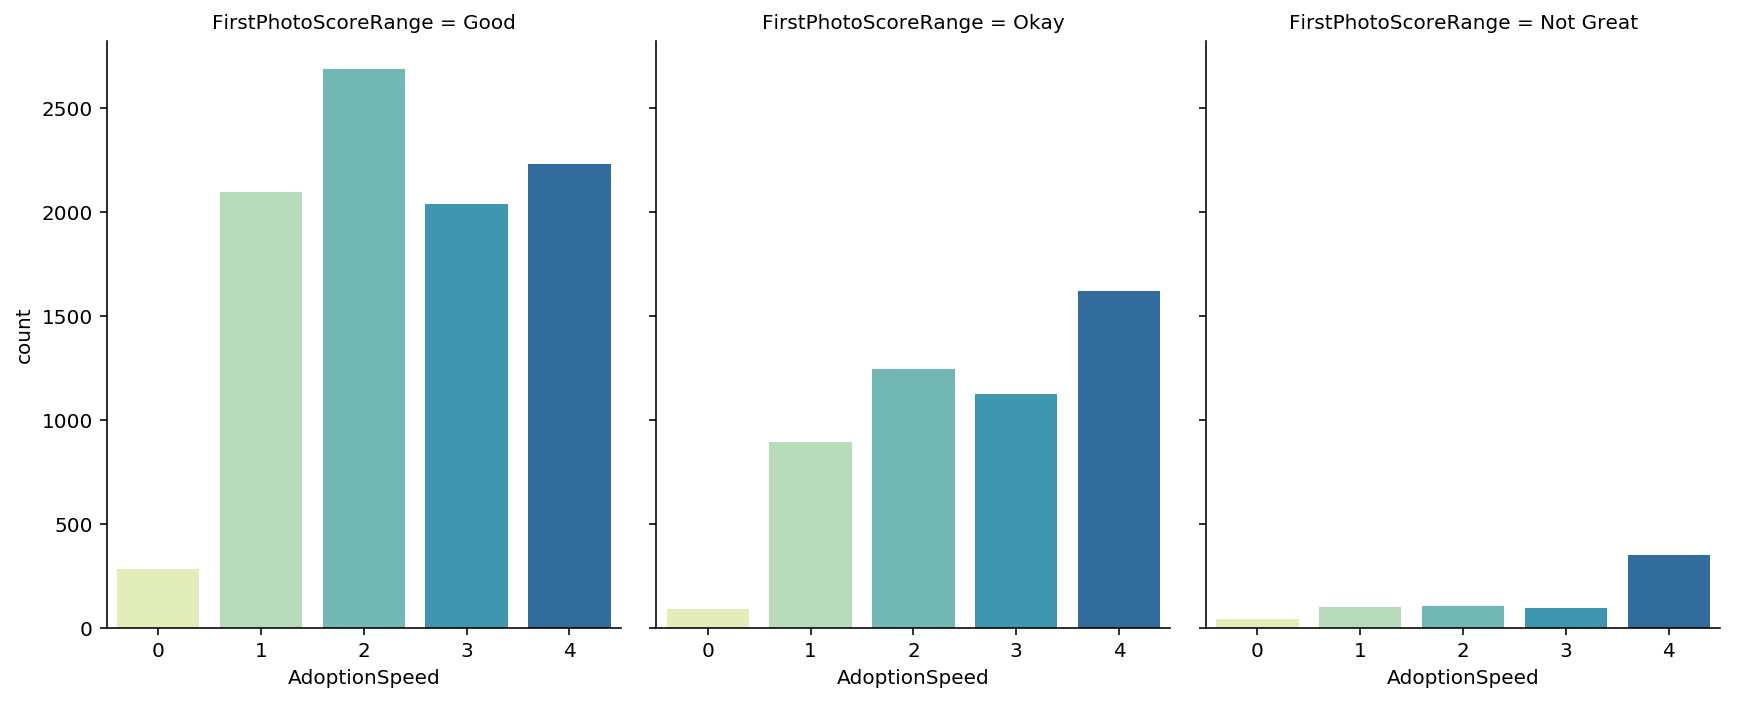

In [219]:
def group_photo_score(x):
    score = x['FirstPhotoScore']
    pet_type = x['Type']
    if pet_type == 1:
        good_threshold = 0.96
    if pet_type == 2:
        good_threshold = 0.99
    if score > good_threshold: 
        return 'Good'
    if (score < good_threshold) & (score > .5): 
        return 'Okay'
    return 'Not Great'
train_df['FirstPhotoScoreRange'] = train_df[['Type','FirstPhotoScore']].apply(lambda x: group_photo_score(x), axis=1)

sns.catplot("AdoptionSpeed", col="FirstPhotoScoreRange",
             data=train_df,
                kind="count", height=5, aspect=.8);

In [100]:
train_df['AllPhotoScores'] = train_df['PetID'].apply(lambda x: get_photo_score(x, match='exact', start=1, stop=99, multiple=False))

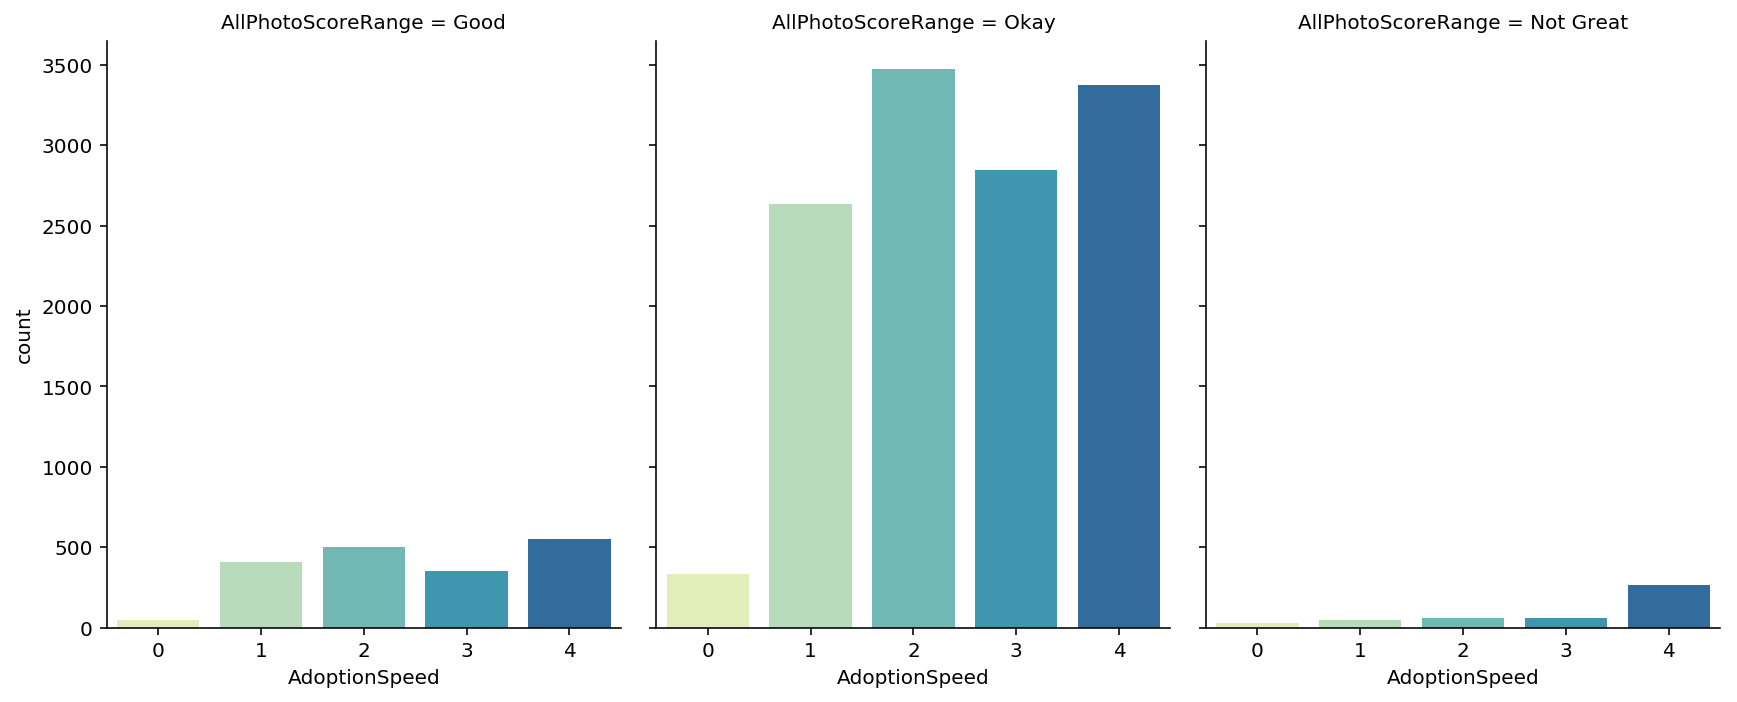

In [203]:
def mean_photo_score(x):
    mean_score = x['AllPhotoScore'] / x['PhotoAmt']
    pet_type = x['Type']
    if pet_type == 1:
        good_threshold = 0.96
    if pet_type == 2:
        good_threshold = 0.99
    if mean_score > good_threshold: 
        return 'Good'
    if (mean_score < good_threshold) & (mean_score > 0): 
        return 'Okay'
    return 'Not Great'

train_df['AllPhotoScoreRange'] = train_df[['AllPhotoScore', 'PhotoAmt', 'Type']].apply(lambda x: mean_photo_score(x), axis=1)

sns.catplot("AdoptionSpeed", col="AllPhotoScoreRange",
                 data=train_df,
                kind="count", height=5, aspect=.8);

In [107]:
train_df['AllPhotoScoresList'] = train_df['PetID']\
    .apply(lambda x: get_photo_score(x, match='exact', start=1, stop=99, multiple=True))

In [209]:
train_df['AllPhotoScoresList'].head()

0                                          [0.9907862]
1                               [0.9812687, 0.9859118]
2    [0.96045667, 0.97326094, 0.9652418, 0.9644904,...
3    [0.97869784, 0.983428, 0.9457797, 0.9561728, 0...
4                          [0.9843458, 0.0, 0.9677062]
Name: AllPhotoScoresList, dtype: object

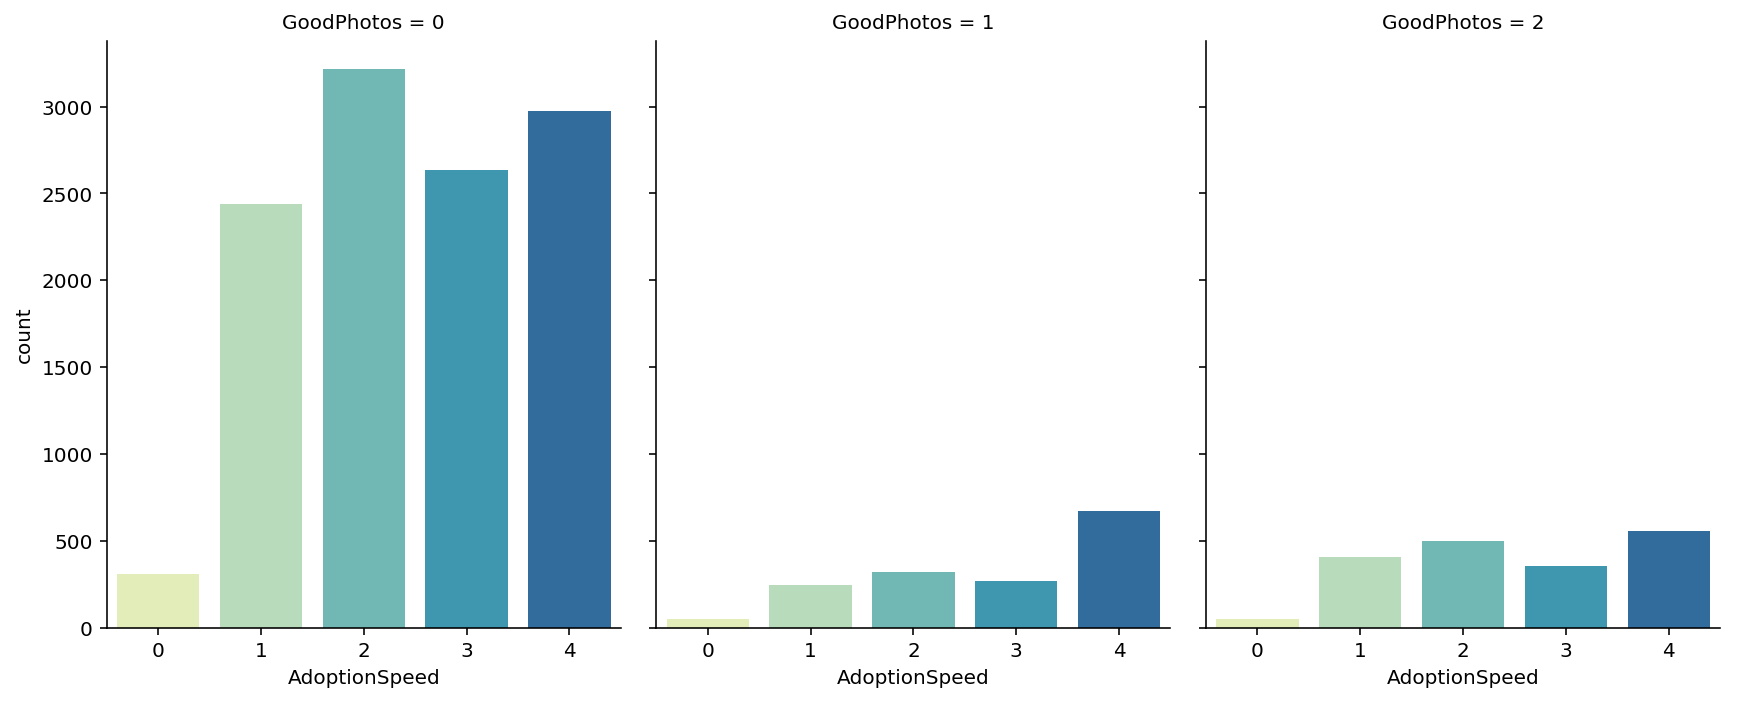

In [204]:
def count_good_photos(x):
    count = 0
    pet_type = x['Type']
    if pet_type == 1:
        good_threshold = 0.96
    if pet_type == 2:
        good_threshold = 0.99
    try:
        count = len(x[x > good_threshold])
    except Exception:
        pass
    if count > 2:
        count = '> 3'
    return count

train_df['GoodPhotos'] = train_df[['Type', 'AllPhotoScoresList']].apply(lambda x: count_good_photos(x), axis=1)

sns.catplot("AdoptionSpeed", col="GoodPhotos",
                 data=train_df,
                kind="count", height=5, aspect=.8);

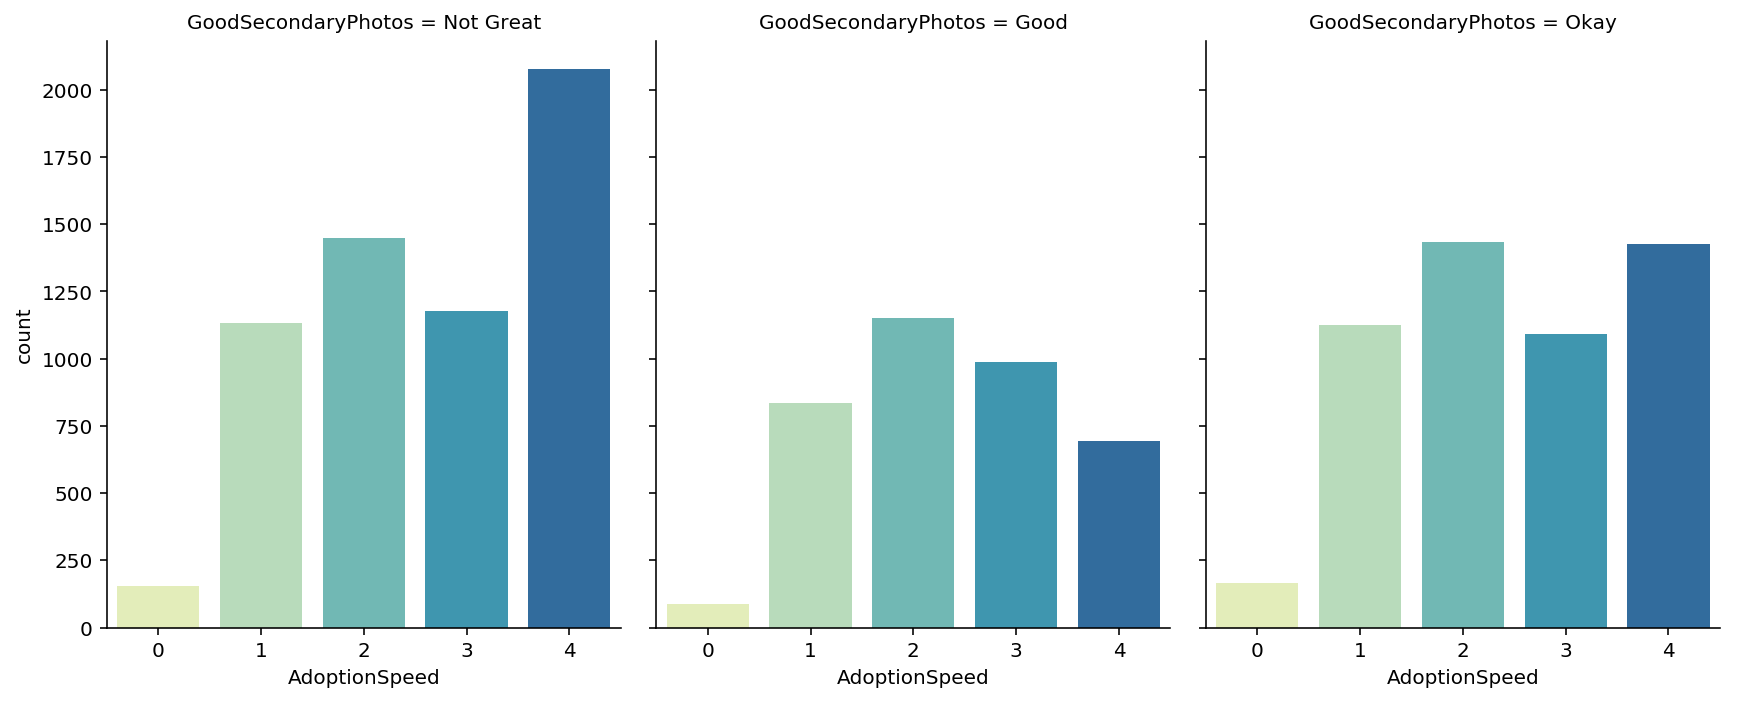

In [213]:
def count_secondary_good_photos(x):
    count = 0
    pet_type = x['Type']
    scores = x['AllPhotoScoresList']
    if pet_type == 1:
        good_threshold = 0.96
    if pet_type == 2:
        good_threshold = 0.99
    try:
        scores = scores[1:]
        count = len(scores[scores > good_threshold])
    except Exception:
        pass
    if count > 2:
        return 'Good'
    if count > 0:
        return 'Okay'
    return 'Not Great'

train_df['GoodSecondaryPhotos'] = train_df[['AllPhotoScoresList', 'Type']].apply(lambda x: count_secondary_good_photos(x), axis=1)

sns.catplot("AdoptionSpeed", col="GoodSecondaryPhotos",
                 data=train_df,
                kind="count", height=5, aspect=.8);

In [216]:
train_df['FirstAndSecondaryPhotos'] =  train_df['FirstPhotoScoreRange'] + '__' + train_df['GoodSecondaryPhotos']

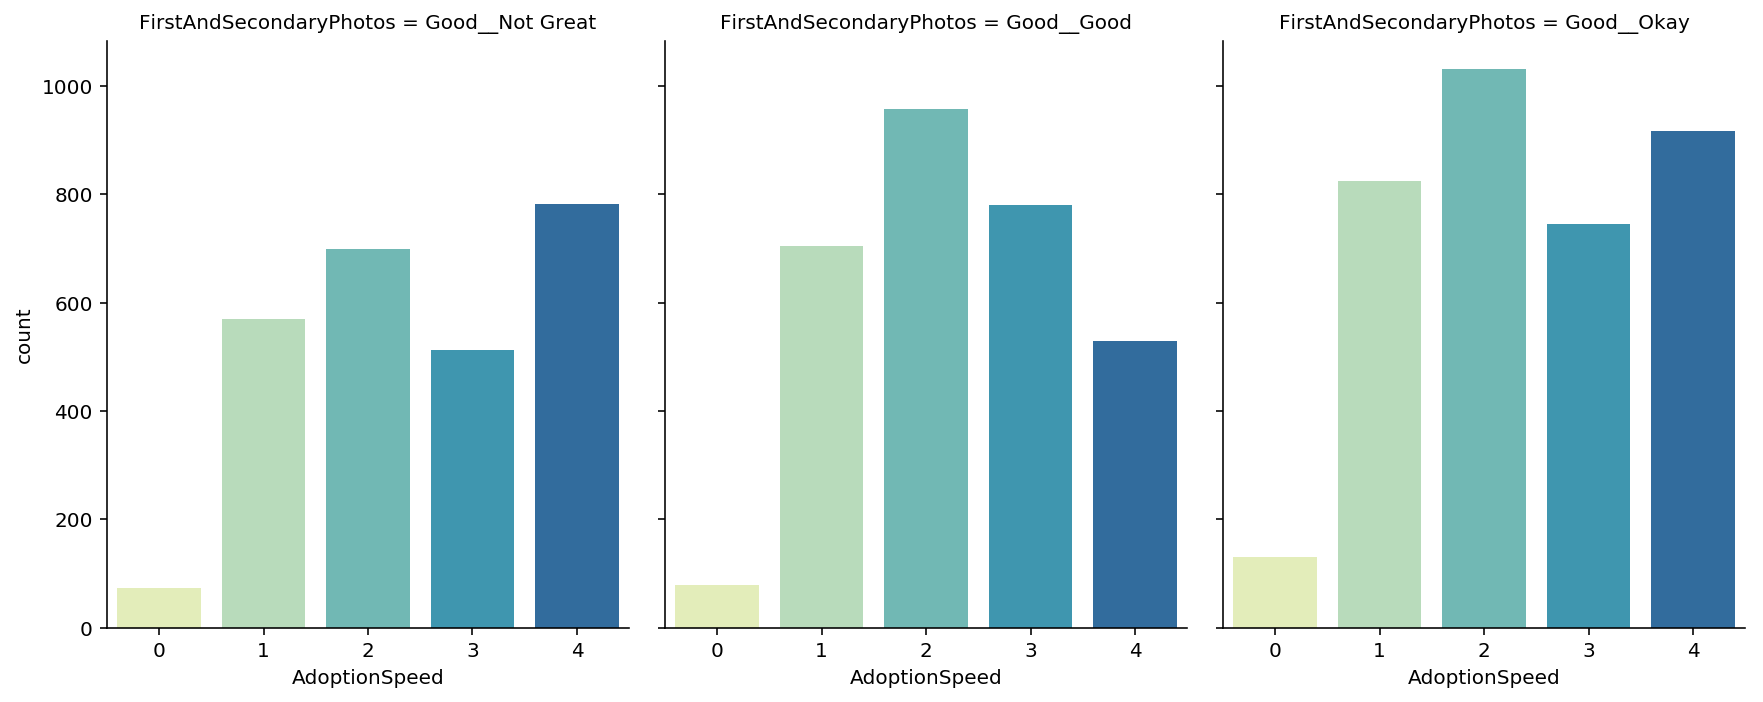

In [221]:
sns.catplot("AdoptionSpeed", col="FirstAndSecondaryPhotos",col_wrap=4,
                 data=train_df[train_df['FirstPhotoScoreRange'] == 'Good'],
                kind="count", height=5, aspect=.8);

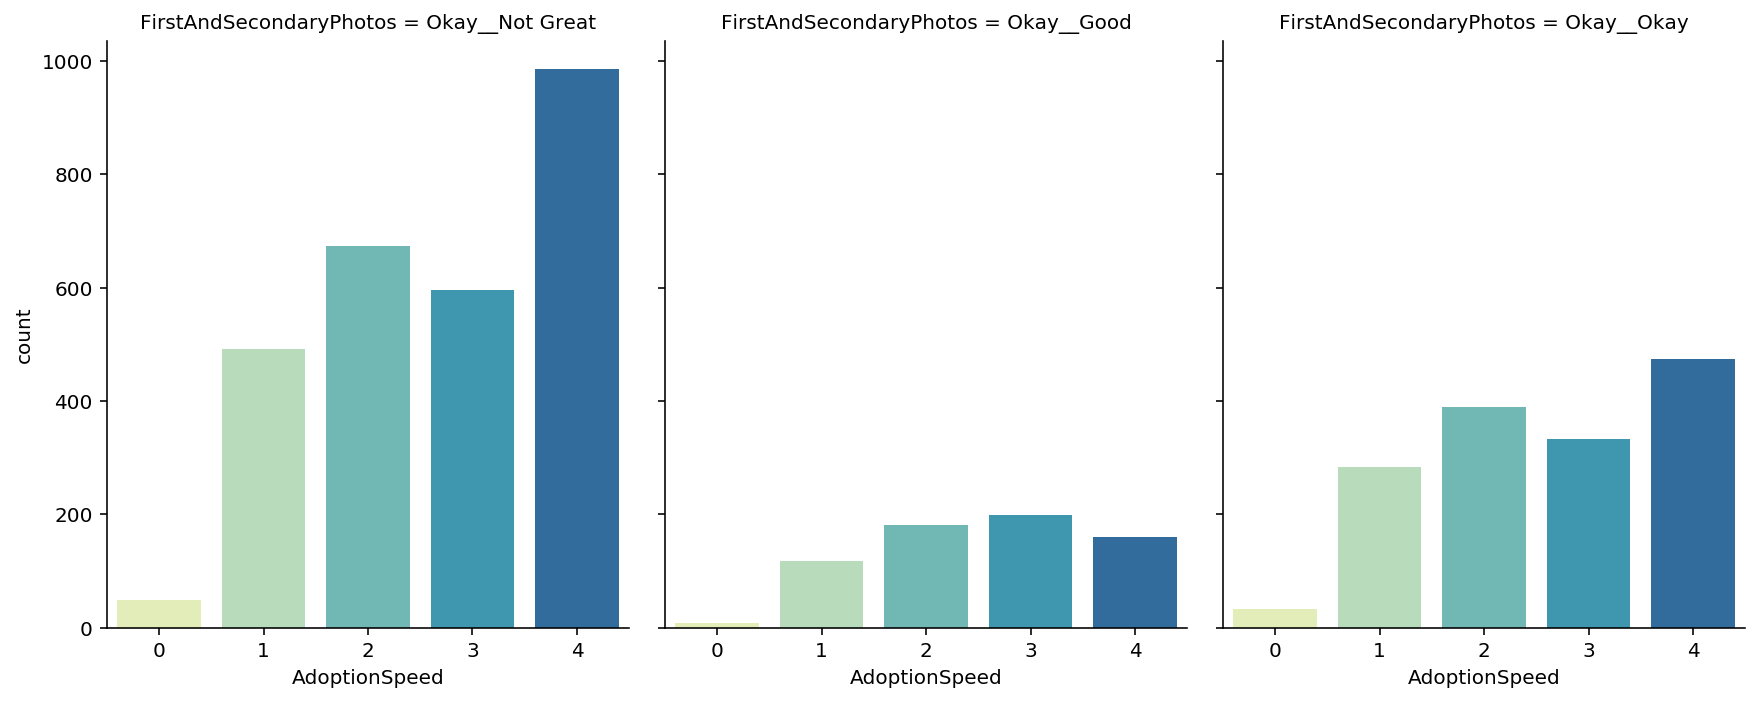

In [222]:
sns.catplot("AdoptionSpeed", col="FirstAndSecondaryPhotos",col_wrap=4,
                 data=train_df[train_df['FirstPhotoScoreRange'] == 'Okay'],
                kind="count", height=5, aspect=.8);

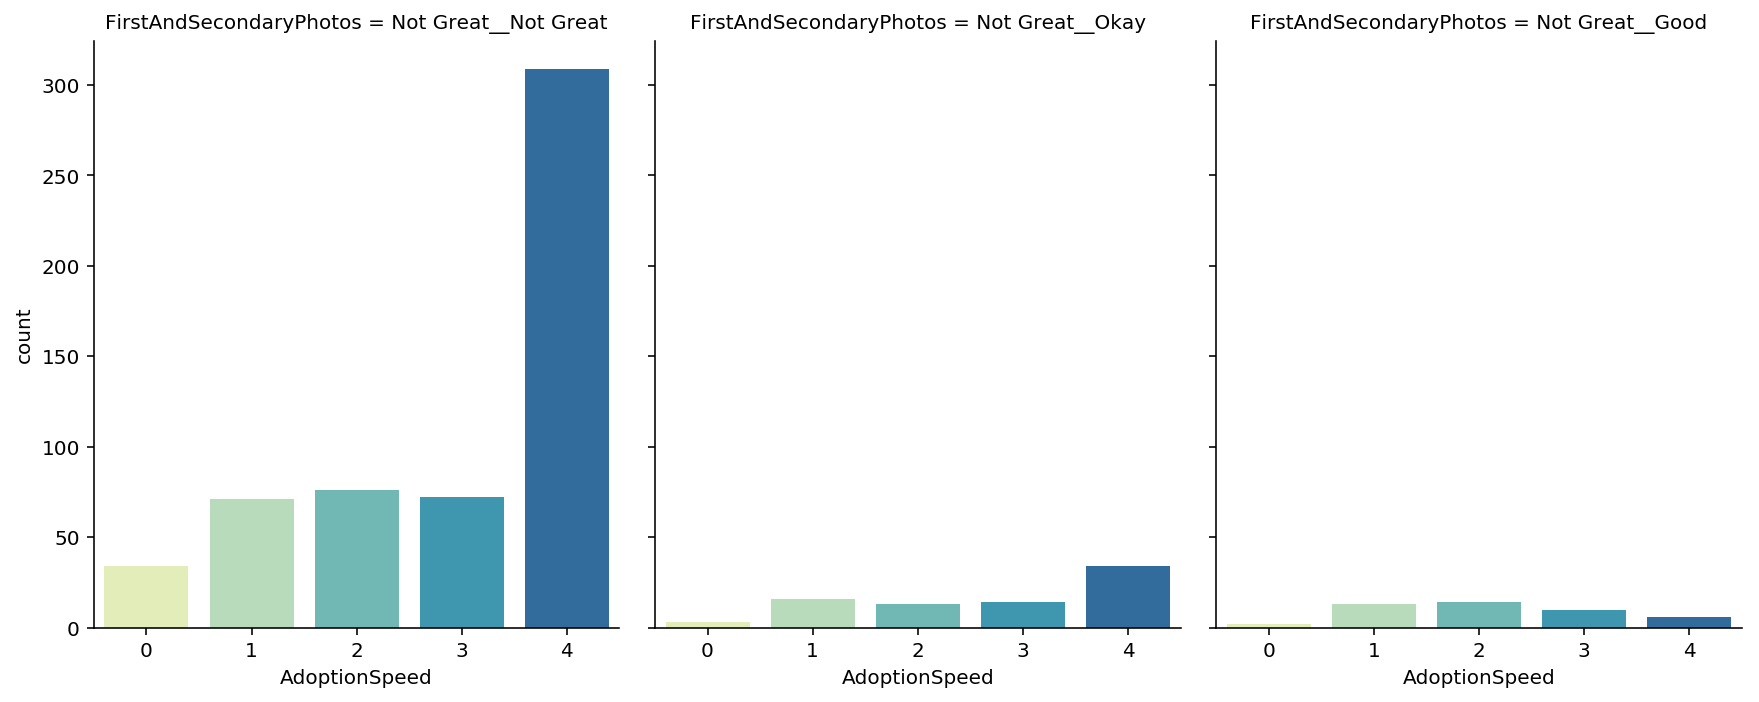

In [223]:
sns.catplot("AdoptionSpeed", col="FirstAndSecondaryPhotos",col_wrap=4,
                 data=train_df[train_df['FirstPhotoScoreRange'] == 'Not Great'],
                kind="count", height=5, aspect=.8);

In [164]:
scores = np.array([34,33,23234,12,45,456,454,6,6])

array([   33, 23234,    12,    45,   456,   454,     6,     6])

## Video

## Description

## Quantity

## Age

## Health

## Breed

## Color

## Size

## Fur

## Gender

## State

## Rescuer